In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Simulate Stock and Volatility Processes

For this project, we shall be using synthetically created prices that follows the Heston model with a mean-reverting volatility process.
$$dS_t = \mu{S_t}dt + \sqrt(v_t)S_tdW^s_t$$
$$dv_t = \kappa(\theta - v_t)dt + \zeta\sqrt{v_t}dW^v_t$$
$$dW^s_tdW^v_t = \rho{dt}$$

Before we begin discretizing the two processes, we need to first know the equations given by Ito's Lemma and Milstein:

Ito's Lemma provides a method for computing the differential of a function of a stochastic process. It looks similar to the Taylor Series and the equation for one variable is given by:
$$df(x) = f'(x)dx + 0.5f''(x)(dx)^2$$

Milstein is similar to the Euler's method, but it provides better accuracy by incorporating the second derivative, making it more suitable for complex dynamics. In our case we have a correlated brownian motion with one process being an input to the other. The equation is given by:
$$dx_t = a(x_t)dt + b(x_t)dW_t$$
$$x_{n+1} = x_n + a(x_n)\triangle{t} + b(x_n)\triangle{W} + 0.5b(x_n)b'(x_n)[(\triangle{W})^2 - \triangle{t}]$$

Using Ito's Lemma and Euler's method, and Milstein's method, we can discretize the stock price process to get the following equations after z-normalizing and truncating variance:
$$d(lnS_t) = (\mu - 0.5v_t)dt + \sqrt{v_t}dW^S_t$$
$$S_{t+1} = S_t\exp\left[(\mu - 0.5v^+_t)\triangle{t} + \sqrt{v^+_t\triangle{t}}z\right]$$
$$v_{t+1} = v_t + \kappa(\theta - v^+_t)\triangle{t} + \zeta\sqrt{v^+_t\triangle{t}}z + \mathbb{1}[v_t \ge 0](\frac{\zeta^2}{4})[\triangle{t}(z^2 - 1)]$$
$$\triangle{W_S} = p\triangle{W_v} + \sqrt{1-p^2}\triangle{W_\perp}$$

In [250]:
class SimulatePrices:
    def __init__(self, start_px:float, start_vol:float, time_steps:int, N:int=252, seed:int|None=None):
        self.start_px = start_px
        self.start_vol = start_vol
        self.time_steps = time_steps
        self.dt = 1/N
        self._rng = np.random.default_rng(seed)
    
    def _volatility(self, prev_vol:float, kappa:float, theta:float, zeta:float, z:float) -> float:
        v = max(prev_vol, 0)
        mean_revert_term = kappa*(theta - v)* self.dt
        
        indicator_func = (v >= 0)
        first_order = zeta* np.sqrt(v*self.dt)* z
        second_order = indicator_func* (zeta**2 /4)* self.dt*(z**2 - 1)
        
        vol = prev_vol + mean_revert_term + first_order + second_order
        return vol
    
    def _brownian_price(self, z_vol:float|np.ndarray, z_perp:float|np.ndarray, p:float) -> float|np.ndarray:
        return p*z_vol + np.sqrt(1-p**2)*z_perp
    
    def _price(self, prev_px:float, mu:float, vol:float, z:float) -> float:
        v = max(vol, 0)
        exp_term = (mu - 0.5*v)*self.dt + np.sqrt(v*self.dt)*z
        px = prev_px*np.exp(exp_term)
        return px
    
    def simulate(self, mu:float, kappa:float, theta:float, zeta:float, p:float) -> tuple[np.ndarray, np.ndarray]:
        S = np.empty(self.time_steps+1)
        V = np.empty(self.time_steps+1)
        S[0] = self.start_px
        V[0] = self.start_vol
        
        z_vol = self._rng.standard_normal(self.time_steps)
        z_perp = self._rng.standard_normal(self.time_steps)
        z_s = self._brownian_price(z_vol, z_perp, p)
        
        for n in range(self.time_steps):
            v = self._volatility(V[n], kappa, theta, zeta, z_vol[n])
            px = self._price(S[n], mu, v, z_s[n])
            S[n+1], V[n+1] = px, v
        
        return S, V

In [251]:
config = {
    'mu':0.25,
    'kappa': 9,
    'theta': 0.25**2,
    'zeta': 1,
    'p': -0.5
}

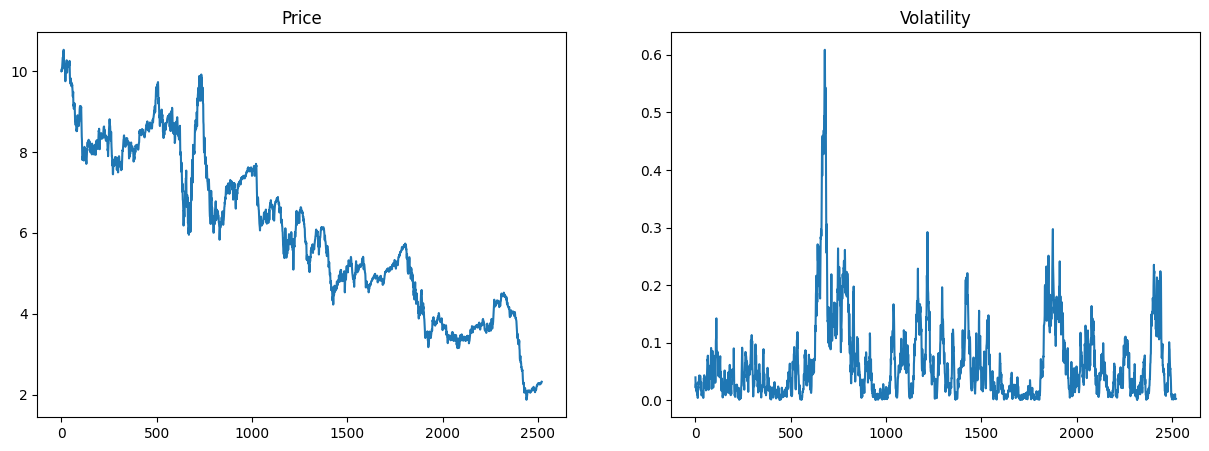

In [252]:
start_px = 10
start_vol = 0.2**2
time_steps = 252*10
sim = SimulatePrices(start_px, start_vol, time_steps)
price, vol = sim.simulate(**config)

fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes[0].plot(price)
axes[0].set_title('Price')
axes[1].plot(vol)
axes[1].set_title('Volatility')
plt.show()

In [253]:
np.random.seed(123)

n_assets= 10
start_px = np.random.lognormal(mean=3, sigma=0.5, size=n_assets)  # stock prices 10–100
start_vol = np.random.uniform(0.05, 0.6, size=n_assets)**2        # starting variance (0.05–0.6)
mu = np.random.uniform(-0.2, 0.3, size=n_assets)                  # annual drift (-20% to +60%)
theta = np.random.uniform(0.05, 0.5, size=n_assets)**2            # long-run variance
kappa = np.random.uniform(0.5, 3.0, size=n_assets)                # mean reversion speed
zeta = np.random.uniform(0.2, 1.0, size=n_assets)                 # vol-of-vol
p = np.random.uniform(-0.5, 0.5, size=n_assets)                   # correlation of shocks

In [254]:
time_steps = 252*10
all_prices = []
all_vols = []

for i in range(n_assets):
    sim = SimulatePrices(start_px[i], start_vol[i], time_steps, seed=123)
    config = {
        'mu':mu[i],
        'kappa': kappa[i],
        'theta': theta[i],
        'zeta': zeta[i],
        'p': p[i]
    }
    price, vol = sim.simulate(**config)
    all_prices.append(price)
    all_vols.append(vol)

all_prices = np.array(all_prices)
all_vols = np.array(all_vols)
df = pd.DataFrame(all_prices.T, columns=[f'stock_{i+1}' for i in range(len(all_prices))])
df.index.name = 'time'
df.head(5)

,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,stock_9,stock_10
time,,,,,,,,,,
0,11.671905,33.071528,23.138300,9.457921,15.039798,45.865732,5.969483,16.208628,37.824919,13.021864
1,11.787391,33.150571,23.261637,9.727484,15.088297,46.191061,6.080398,16.413930,38.715366,13.116723
2,11.539592,33.008334,22.792564,9.453979,14.924817,45.746866,5.949206,15.995695,37.771135,12.590152
3,11.823661,33.256909,23.399664,9.590930,15.129895,46.105590,6.038964,16.434271,38.253772,13.233498
4,12.086698,33.483323,23.874757,9.856809,15.299211,46.627477,6.175869,16.858110,39.175665,13.723027


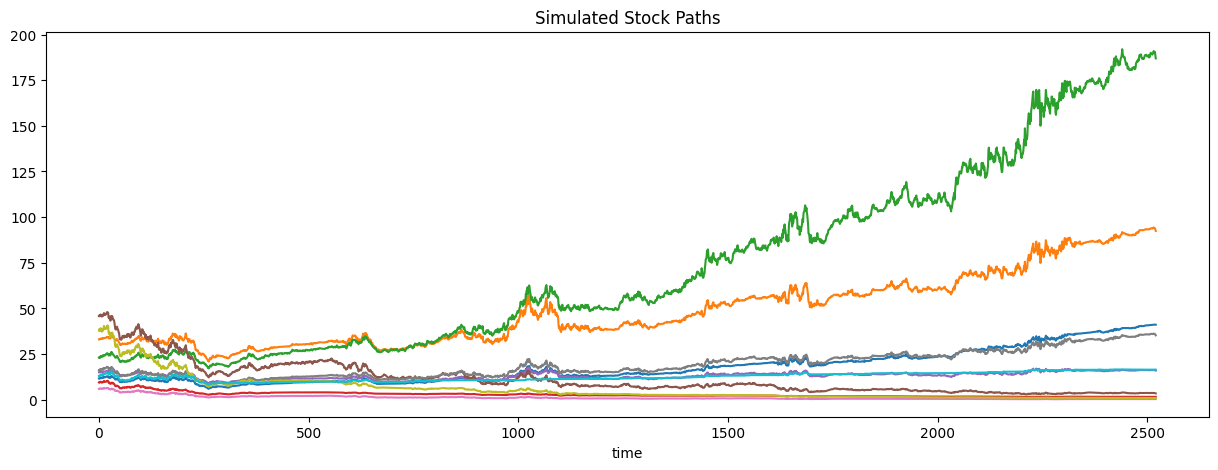

In [255]:
df.plot(figsize=(15,5), legend=False)
plt.title('Simulated Stock Paths')
plt.show()

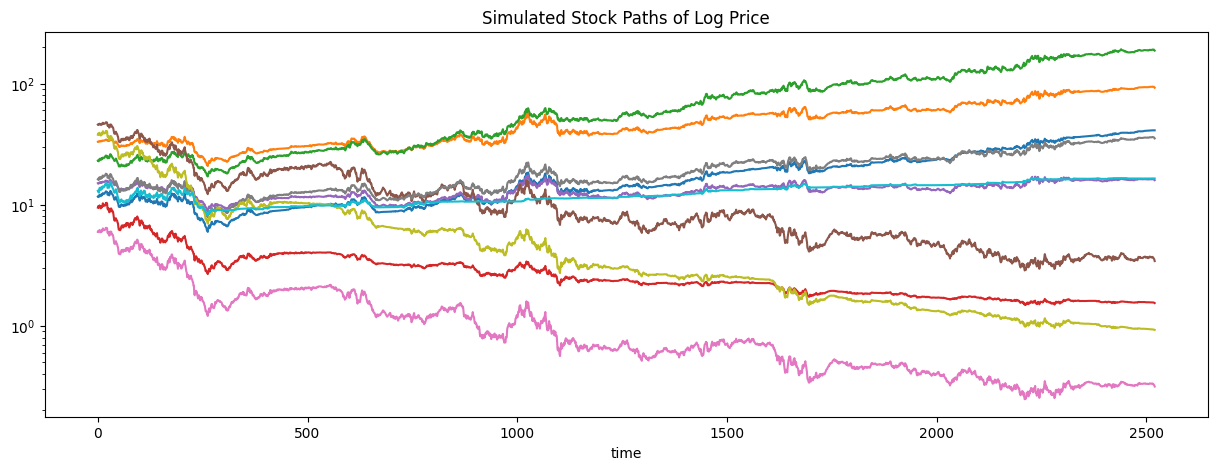

In [256]:
df.plot(figsize=(15,5), legend=False)
plt.yscale('log')
plt.title('Simulated Stock Paths of Log Price')
plt.show()

# Feature Engineering

Now that we have our simulated stock prices, we will create a few simple indicators.

In [257]:
class Features:
    def __init__(self, prices:pd.Series):
        self.prices = prices.copy()
    
    def log_returns(self) -> pd.Series:
        return np.log(self.prices/self.prices.shift(1))
    
    def sma_ratio(self, window:int) -> pd.Series:
        sma = self.prices.rolling(window).mean()
        return self.prices/sma
    
    def rsi(self, window:int) -> pd.Series:
        delta = self.prices.diff(1)
        gain = delta.clip(lower=0)
        loss = delta.clip(upper=0)
        
        avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()
        
        rs = avg_gain/avg_loss
        rsi = 100 - (100/ (1+rs))
        return rsi
    
    def pipeline(self, sma_window:int=14, rsi_window:int=14) -> pd.DataFrame:
        f_log_returns = self.log_returns()
        f_sma_ratio = self.sma_ratio(sma_window)
        f_rsi = self.rsi(rsi_window)
        features = np.array([f_log_returns, f_sma_ratio, f_rsi])
        
        col_names = ['log_returns', 'sma_ratio', 'rsi']
        df = pd.DataFrame(features.T, columns=col_names).dropna()
        return df

In [258]:
f = Features(df['stock_1'])
stock_1 = f.pipeline()
stock_1.head(5)

,log_returns,sma_ratio,rsi
13,-0.018657,1.019128,178.245333
14,0.003747,1.019362,174.354303
15,0.002861,1.019190,171.424291
16,0.002636,1.017116,168.729058
17,0.018477,1.031603,153.368049


In [259]:
def build_features(prices_df:pd.DataFrame, sma_window:int, rsi_window:int) -> pd.DataFrame:
    feature_dfs = []
    for col in prices_df.columns:
        f = Features(prices_df[col])
        df_temp = f.pipeline(sma_window, rsi_window)
        df_temp = df_temp.add_prefix(f'{col}_')
        feature_dfs.append(df_temp)
    df = pd.concat(feature_dfs, axis=1)
    return df

feature_df = build_features(df, 14, 14)
feature_df.head(5)

,stock_1_log_returns,stock_1_sma_ratio,stock_1_rsi,stock_2_log_returns,stock_2_sma_ratio,stock_2_rsi,stock_3_log_returns,stock_3_sma_ratio,stock_3_rsi,stock_4_log_returns,...,stock_7_rsi,stock_8_log_returns,stock_8_sma_ratio,stock_8_rsi,stock_9_log_returns,stock_9_sma_ratio,stock_9_rsi,stock_10_log_returns,stock_10_sma_ratio,stock_10_rsi
13,-0.018657,1.019128,178.245333,-0.005471,1.007766,176.752325,-0.011694,1.018515,192.730919,-0.045658,...,176.967873,-0.023638,1.019958,179.808647,-0.040964,1.009692,173.205278,-0.020494,1.025459,227.726583
14,0.003747,1.019362,174.354303,0.001192,1.007566,172.775370,0.000941,1.016207,190.993440,0.014118,...,170.565769,0.004859,1.021061,175.525852,0.011765,1.018902,166.976017,-0.000586,1.020228,229.720055
15,0.002861,1.019190,171.424291,0.001545,1.007782,167.859351,0.006431,1.019396,179.933920,-0.012404,...,183.553729,0.001864,1.019875,173.882370,-0.011280,1.007256,183.064295,0.011666,1.027192,209.112523
16,0.002636,1.017116,168.729058,0.001200,1.007260,164.224493,0.002905,1.017371,175.451804,0.000387,...,182.880917,0.002596,1.017449,171.542291,-0.000029,1.005254,183.113030,0.004061,1.023287,202.933464
17,0.018477,1.031603,153.368049,0.008398,1.013935,145.693133,0.022201,1.035336,151.420130,-0.001217,...,179.081434,0.018863,1.032186,157.210643,-0.000937,1.003311,184.818262,0.039702,1.056841,163.957588


# About Reinforcement Learning

In Reinforcement Learning, there are three main components: (i) Environment, (ii) Policy, and the (iii) Value.

Actor-Critic Architecture:

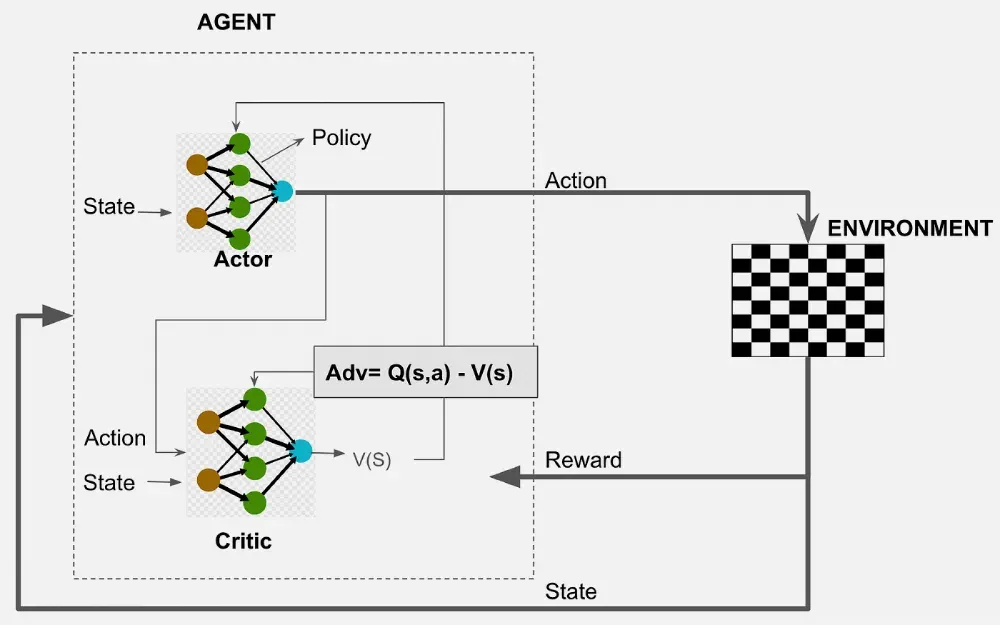

Source: https://www.geeksforgeeks.org/machine-learning/actor-critic-algorithm-in-reinforcement-learning/

## Environment
The environment defines the world in which the agent acts. It tells the agent the current situation (state), what happens when it acts (next state) and how good the action was (reward). The idea is that the agent would iteratively go through the same data for $n$ episodes and improve itself through each iteration.

Using our features, we will need to create an environment for our agent to interact with. In our case, it will be our portfolio and our agent will be adjusting the weights. For simplicity sake, we shall allocate fractions of capital into each asset without worrying about actual share prices. Basically, we allow for fractional shares and free transaction cost.

In [260]:
class PortfolioEnv:
    def __init__(self, df:pd.DataFrame, initial_balance:float=1000):
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.reset()
    
    def reset(self) -> np.ndarray:
        self.balance = self.initial_balance
        self.t = 0
        return self._getstate()
    
    def _getstate(self) -> np.ndarray:
        return self.df.iloc[self.t].values.astype(np.float64)
    
    def _getreturns(self) -> np.ndarray:
        return_cols = self.df.filter(like='log_returns')
        return_vals = return_cols.iloc[self.t+1].values #next day return
        return return_vals
    
    def step(self, weights:np.ndarray) -> tuple[np.ndarray, float, bool, dict]:
        norm_weights = weights/ (weights.sum() + 1e-8) #Enforces that weights sum to 1
        
        return_vals = self._getreturns()
        reward = norm_weights@return_vals
        self.balance *= np.exp(reward)
        
        self.t += 1
        done = self.t >= (len(self.df) - 2)
        return self._getstate(), reward, done, {'balance': self.balance}

 In order to test that our environment works, we will have a random agent to take action.

In [261]:
class RandomWeightAgent:
    def __init__(self, n_assets):
        self.n_assets = n_assets

    def choose_action(self, state):
        w = np.abs(np.random.normal(0, 1, size=self.n_assets))
        return w

def run_random(env, agent, episodes=5):
    for ep in range(episodes):
        state = env.reset()
        done = False
        while not done:
            weights = agent.choose_action(state)
            state, reward, done, info = env.step(weights)
        print(f"Episode {ep+1}:\n   Final balance {info['balance']:.4f}")

In [262]:
env = PortfolioEnv(feature_df)
agent = RandomWeightAgent(n_assets=n_assets)
run_random(env, agent, episodes=5)

Episode 1:
   Final balance 553.5036
Episode 2:
   Final balance 566.4261
Episode 3:
   Final balance 568.3424
Episode 4:
   Final balance 754.9610
Episode 5:
   Final balance 578.3150


## Policy

The policy acts like the brain of the agent, it tells the agent what action to take given its current state. The policy could be either deterministic or stochastic.
$$\pi(a|s) = P(\text{Take Action given State})$$

A deterministic policy always outputs the same action for the same state. For example, if RSI>70, sell.
$$a_t = \mu_{\theta}(s_t)$$

A stochastic policy outputs a probability distribution over actions, then samples to encourage exploration. For example, if RSI>70, 80% sell, 20% hold.
$$a_t \sim \pi_{\theta}(\cdot | s_t)$$

### Stochastic Policy
To elaborate more on the stochastic policy, imagine that the policy outputs $\mu = [0.3, 0.7]$ and $\sigma = [0.05, 0.05]$. We would take the values as our Gaussian parameters where $w \sim N(\mu_i, \sigma^2_i)$. Essentially, given the current state, the policy has a best guess that the action is around $\mu(s_t)$ and is uncertain by about $\sigma(s_t)$.

Lets imagine that we have a neural network with 2 layers, both using Linear -> (tanh or ReLU variants) to bound the values between [-1, 1]:

The output at the end of the first two layers will have the following equation:
$$h = f(W_2f(W_1s_t + b_1) + b_2)$$

Then, we will branch into two different layers:
$$\mu_{\theta}(s_t) = W_{\mu}h + b_{\mu}$$
$$log\sigma_{\theta}(s_t) = W_{\sigma}h + b_{\sigma}$$

Using the outputs, we will parameterize our Gaussian distribution.
$$\sigma_{\theta} = \exp(log\sigma_{\theta})$$
$$a_i \sim N(\mu_i, \sigma^2_i)$$

For the basics on the next block of code, refer to: https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [263]:
#Actor
class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, n_assets, hidden_dim:int=32):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu_head = nn.Linear(hidden_dim, n_assets)
        self.log_std_head = nn.Linear(hidden_dim, n_assets)
    
    def forward(self, x):
        x = self.shared(x)
        mu = self.mu_head(x)
        log_std = self.log_std_head(x).clamp(-5, 3)  #Ensures a reasonable range
        std = torch.exp(log_std)
        return mu, std

### On-Policy vs Off-Policy

Then, we normalize the output using either Softmax (Long only) or tanh (Long and Short). Compute the reward and backpropagate to update $\mu$ and $\sigma$. However, we cannot backpropagate as sampling is not differentiable. Therefore, we need to connect random samples back to the network parameters during training, which depending on the policy method, we have certain tricks to resolve this issue.

Before we dive into the tricks, we must first understand the state value (V), action value (Q) and advantage function (A).
- $V^\pi(s_t)$ is the expected return from state $s_t$, following policy $\pi$ (average of all possible actions).
- $Q^\pi(s_t, a_t)$ is the expected return from state $s_t$, taking action $a$, then following policy $\pi$ (average of all possible futures given an action).
- $A^\pi(s_t, a_t)$ is given by $Q^\pi(s_t, a_t) - V^\pi(s_t)$ and a positive value means that the action is better than the average, increasing the probability of that action being chosen.

Since we are working the Gaussian distribution, our log probability is given by:
$$\pi(a|s) = \prod^k_{i=1}\frac{1}{\sqrt{2\pi\sigma^2_i}}e^{-\frac{(a_i - \mu_i)^2}{2\sigma^2_i}}$$
$$log\pi(a|s) = -0.5\left[\sum^k_{i=1}\frac{(a_i - \mu_i)^2}{\sigma^2_i} + 2\sum^k_{i=1}log\sigma_i + klog2\pi\right]$$

On-Policy uses the likelihood ratio trick to reward the probability of good actions. It must use trajectories generated by the current version of the policy. For example, PPO, A2C and REINFORCE.
$$\nabla_{\theta}J(\theta) = E\left[\nabla_{\theta}log\pi_{\theta}(a_t | s_t)\hat{A}_t\right]$$
where $\nabla_{\theta}J(\theta)$ and $\hat{A}_t$ denotes the gradient and advantage function respectively.
$$r_t(\theta) = \exp(log\pi_{\theta} - log\pi_{\theta_{old}})$$
$$L^{PPO}_{actor}(\theta) = E\left[min(r_t(\theta)\hat{A}_t, \quad clip(r_t(\theta), 1 - \epsilon, 1 + \epsilon)\hat{A}_t \right]$$
where $\hat{A}_t$ and $\epsilon$ denotes the advantage function and clipping hyperparameter respectively.

Off-Policy uses the reparameterization trick to isolate the randomness in $\epsilon$ and pass $a_t$ as input to $Q$ in our loss function. It can use trajectories generated by older policies. For example, SAC, DDPG, and TD3.
$$a_t = \mu_{\theta}(s_t) + \sigma_{\theta}(s_t)\epsilon_t, \quad \epsilon_t \sim N(0, 1)$$
$$L^{SAC} = E[\alpha{log\pi(a|s)} - Q_{\phi}(s, a)]$$

Notice that in the on-policy method, we are using the ratio between the two log probability. Meanwhile in the off-policy method, we are inputting action into the loss function.

For detailed explanation on backpropagation, refer to the following source: https://www.datacamp.com/tutorial/mastering-backpropagation

## Value

Since we plan to implement the Proximal Policy Optimization (PPO) model, we need the advantage function. Q can be calculated based on the (discounted) weighted average return, but V needs to be approximated. This is where the critic comes in, it handles our Value Neural Network, which approximates the state-value function by minimizing the following loss function:
$$L_{critic}(\phi) = (V_{\phi}(s_t) - \hat{R_t})^2$$

Note that our loss function is trying to minimize the mean-squared error between the predicted value and estimated return $\hat{R_t}$. However, we do not have $\hat{R_t}$.

In [264]:
#Critic
class ValueNet(nn.Module):
    def __init__(self, state_dim:int, hidden_dim:int=32):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x:torch.Tensor):
        return self.fc(x)

### Estimation of Expected Return
There are a few ways to get $\hat{R_t}$, an empirical return estimate that acts like a sample estimate of $Q$:
- Monte Carlo Simulation estimate the return by running complete episodes and averaging the total rewards observed. It is an unbiased estimator of return at the cost of high variance.
$$G_t = \sum^{T-t-1}_{k=0}\gamma^kR_{t+k+1}$$
$\qquad$ where $T$ is the final timestep and $t$ is the current timestep.

For example:
- Start: $k=0 \rightarrow R_{t+1}$
- Next: $k=1 \rightarrow R_{t+2}$
- End: $k=T-t-1 \rightarrow (R_{t+T-t-1+1} = R_{T})$

- Temporal Difference (TD) bootstraps from existing value estimates where updates are based on observed rewards plus estimated future values (one-step lookahead). For the first episode, we can initialize the values as 0. It has lower variance but introduces bias as it relies on current value estimates.
$$V_{obs}(s_t) = R_{t+1} + \gamma{V(s_{t+1})}$$
$$\delta_t = V_{obs}(s_t) - V(s_t)$$
$$V(s_t) \leftarrow V(s_t) + \alpha\delta_t$$

Sources:
- https://www.geeksforgeeks.org/machine-learning/monte-carlo-policy-evaluation/
- https://www.geeksforgeeks.org/deep-learning/temporal-difference-td-learning/

### Generalized Advantage Estimation
In our case, we shall use Generalized Advantage Estimation (GAE) as we do not want to overfit or have a range too large for returns. It combines both Monte Carlo and TD by mixing different step returns with a parameter $\lambda$ to control the bias-variance tradeoff.
$$G_t = \sum^{T-t-1}_{k=0}\gamma^kR_{t+k+1}$$
$$G^{\lambda}_t = (1-\lambda)\sum^{\infty}_{n=1}\lambda^{n-1}G^n_t$$

Note that for GAE, if $\lambda$ is set to 0 or make it approach 1, we get the TD(0) target and Monte Carlo equation respectively. 
$$G^{0}_t = (1-0)\sum^{\infty}_{n=1}0^{n-1}G^n_t$$
$$G^{0}_t = G^{1}_t$$

According to Bellman Equation, $V(s_t) = E[R_{t+1} + \gamma{V(s_{t+1})}]$:
$$G^{1}_t = R_{t+1} + \gamma{V(s_{t+1})} = V_{obs}(s_t)$$

Moving on to the calculation of the advantage function $\hat{A_t} = G^{\lambda}_t - V(s_t)$, if we expand $G^{\lambda}_t$ and use the equations given for TD, we get the following:
$$\hat{A_t} = \delta_t + \gamma\lambda(\delta_{t+1}) + (\gamma\lambda)^2(\delta_{t+2}) + ...$$

However, this is difficult to implement in code, so we can implement the infinite sum backwards:
$$\hat{A_t} = \delta_t + \gamma\lambda(\hat{A}_{t+1})$$

Source: https://towardsdatascience.com/generalized-advantage-estimate-maths-and-code-b5d5bd3ce737/

In [265]:
def compute_gae(rewards:list[float], values:list[float], dones:list[bool], gamma:float, lamda:float) -> tuple[torch.Tensor, torch.Tensor]:
    T = len(rewards)
    advantages = np.zeros(T, dtype=np.float32)
    gae = 0.0
    values = values + [0] #for looping index
    
    for t in reversed(range(T)):
        indicator_func = (1 - dones[t]) #if terminal, done=True, but we want to multiply by 0, so 1-True = 0
        v_obs = rewards[t] + gamma* values[t+1]* indicator_func
        delta = v_obs - values[t]
        gae = delta + (gamma* lamda* gae)* indicator_func
        advantages[t] = gae
    
    returns = advantages + values[:-1]
    advantages_tensor = torch.tensor(advantages, dtype=torch.float32)
    returns_tensor = torch.tensor(returns, dtype=torch.float32)
    
    return advantages_tensor, returns_tensor 

# Putting Everything Together

In summary, for each epsiode:
- We have an agent that outputs a probability distribution for actions to take. Once we select an action, we get the reward.
- At the same time, we have a critic. It tries to approximate $V$ using the same features.
- After going through every time step, we use our approximate $V$ and reward as inputs to an estimation function for $\hat{R_t}$.
- We calculate our $A$ using $\hat{R_t}$ as our proxy for $Q$. Consequently, we can calculate our policy loss and value loss.
- Lastly, we feed this loss back into our model to adjust its weights for $n$ times and start again till all episodes are iterated.

In [266]:
class PPOAgent:
    def __init__(self, state_dim:int, n_assets:int, lr:float=3e-4, gamma:float=0.99, clip_eps:float=0.2, lamda:float=0.95):
        self.policy = GaussianPolicy(state_dim, n_assets)
        self.value = ValueNet(state_dim)
        
        #Optimizer
        params = list(self.policy.parameters()) + list(self.value.parameters())
        self.optimizer = optim.Adam(params, lr=lr)
        
        #PPO
        self.clip_eps = clip_eps
        
        #GAE
        self.gamma = gamma
        self.lamda = lamda

    def choose_action(self, state:np.ndarray) -> tuple[np.ndarray, torch.Tensor, torch.Tensor, torch.Tensor]:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0) #Pytorch expect [batchsize, features]
        
        #Sample weights
        mu, std = self.policy(state)
        dist = torch.distributions.Normal(mu, std)
        z = dist.sample()
        
        #Get Variables
        weights = torch.softmax(z, dim=-1) #dim=-1 selects the last dimension, features in our case. Size is already based on total assets.
        weights = weights.squeeze(0).detach().numpy() #Get features, detach tensor from network, convert to numpy for PortfolioEnv
        
        log_prob = dist.log_prob(z).sum(dim=-1)
        log_prob = log_prob.detach()
        
        z = z.detach()
        
        return weights, log_prob, z, dist

In [267]:
class LossFunctions:
    def __init__(self):
        pass
    
    def policy_loss_func(self, log_probs:torch.Tensor, old_log_probs:torch.Tensor, advantage:torch.Tensor, tol:float) -> torch.Tensor:
        ratio = torch.exp(log_probs - old_log_probs)
        clip_func = torch.clamp(ratio, 1-tol, 1+tol)*advantage
        choice = torch.min(ratio*advantage, clip_func) 
        return -choice.mean() #Optimizer set to minimize so we flip the sign, alternatively you can set it to maximize
    
    def value_loss_func(self, returns:torch.Tensor, values:torch.Tensor) -> torch.Tensor:
        diff = returns-values
        mse = diff.pow(2)
        return mse.mean()
    
    def total_loss(self, policy_loss:torch.Tensor, value_loss:torch.Tensor, value_coef:float=0.5) -> torch.Tensor:
        return policy_loss + value_coef*value_loss

In [268]:
class RolloutBuffer:
    def __init__(self):
        self.states, self.actions, self.log_probs = [], [], []
        self.rewards, self.dones, self.values = [], [], []
    
    def add(self, state:np.ndarray, action:torch.Tensor, log_prob:torch.Tensor, reward:float, done:bool, value:float):
        self.states.append(state)
        self.actions.append(action.numpy())
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)
        
    def clear(self):
        self.__init__()

In [269]:
def train_ppo(env:PortfolioEnv, agent:PPOAgent, loss_func:LossFunctions, value_loss_coef:float=0.5, epochs=10, timesteps=256, update_steps=32):
    for ep in range(epochs):
        buffer = RolloutBuffer()
        state = env.reset()
        ep_reward = 0
        
        # Go through the data
        for _ in range(timesteps):
            weights, log_prob, action, dist = agent.choose_action(state)
            
            state_tensor = torch.tensor(state, dtype=torch.float32)
            value = agent.value(state_tensor).item() #No unsqueeze as we are getting a scalar anyways
            
            next_state, reward, done, info = env.step(weights)
            buffer.add(state, action, log_prob, reward, done, value)
            
            state = next_state
            ep_reward += reward #reward is log return, so we can sum
            if done:
                break
        
        # Compute GAE
        advantages, returns = compute_gae(buffer.rewards, buffer.values, buffer.dones, agent.gamma, agent.lamda)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8) #Improve stability and convergence
        
        # Convert to tensors
        states = torch.tensor(buffer.states, dtype=torch.float32)
        actions = torch.tensor(buffer.actions, dtype=torch.float32)
        old_log_probs = torch.stack(buffer.log_probs).detach()
        
        # Update PPO
        for _ in range(update_steps):
            mu, std = agent.policy(states)
            dist = torch.distributions.Normal(mu, std)
            log_probs = dist.log_prob(actions).sum(dim=-1)
            
            values = agent.value(states).squeeze()
            
            policy_loss = loss_func.policy_loss_func(log_probs, old_log_probs, advantages, tol=agent.clip_eps)
            value_loss = loss_func.value_loss_func(returns, values)
            loss = loss_func.total_loss(policy_loss, value_loss, value_loss_coef)
            
            agent.optimizer.zero_grad() #clear old gradients
            loss.backward() #compute new gradients
            agent.optimizer.step() #update weights
        
        ep_reward = np.exp(ep_reward) - 1 #Convert back to simple return
        print(f"Epoch {ep+1}: Reward={ep_reward:.4%}, Balance={info['balance']:.6f}")

In [270]:
state_dim = feature_df.shape[1]
n_assets = len([c for c in feature_df.columns if "log_returns" in c])

env = PortfolioEnv(feature_df)
agent = PPOAgent(state_dim, n_assets)
loss = LossFunctions()

train_ppo(env, agent, loss, epochs=10, timesteps=256)

Epoch 1: Reward=-57.3482%, Balance=426.517712
Epoch 2: Reward=-63.5874%, Balance=364.125860
Epoch 3: Reward=-58.5027%, Balance=414.973440
Epoch 4: Reward=-64.0123%, Balance=359.876740
Epoch 5: Reward=-57.7005%, Balance=422.994552
Epoch 6: Reward=-53.4293%, Balance=465.706966
Epoch 7: Reward=-63.4450%, Balance=365.550425
Epoch 8: Reward=-53.9988%, Balance=460.012184
Epoch 9: Reward=-52.8312%, Balance=471.687913
Epoch 10: Reward=-61.5062%, Balance=384.938267
